For the sake of safety in case of one of us making a dumb mistake we elected to make two seperate codebasees to solve this, the other is the primary one and this is the alternative, altough there are still situations in wich the graphs from this code are used

This is for the second extension

In [1]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import cvxpy as cp
import time
import gurobipy
import seaborn
import gurobipy
from pyDOE import lhs


We here construct the full problem from this subsection with nreal realisations of alpha instead of the continuous distribution

In [6]:
nreal = 20
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
ps = [0.6,0.4]
ts2 = [5,7.5]
ts3 = [0.5,1.75]
timecostvecs = [[10*ps[a]*ps[b],ts2[a]*ps[a]*ps[b],ts3[b]*ps[a]*ps[b]] for a in range(2) for b in range(2)]
costsvec= [v*i*p/nreal for p in probs for t in range(4) for v in timecostvecs[t]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage

cset = cinstall+costsvec*nreal

randvals= np.random.uniform(size=nreal*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals =  cp.Parameter(shape=nreal*4 ,value= [randvals[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)])
x=cp.Variable(len(cset) )


#phase 1 constraints
#budget
constr = [x>=0]
constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
print(len(cset))

base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5+4]@multidin2<= demands[(k//12)%27][k%3] for k in range(nreal*27*3*4)]
print([0,1,2,3,4][0:4])
print(constr[-1])
#capacity
base= np.array([4,9,14]) 
multiding = np.array([1,1,1])
constr = constr + [x[k]*randvals[(v//108)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(108*nreal) for k in range(4)]
print(constr[-1])


32404
[0, 1, 2, 3]
-var24127[32399 32400 32401 32402 32403] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= var24127[3] @ param24126[79] + -var24127[32392 32397 32402] @ [1. 1. 1.]


Compile the problem

In [7]:
cset = np.array(cset)
problem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= problem.solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(problem.value)  
print( problem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 22 08:44:00 PM: Your problem has 32404 variables, 47525 constraints, and 80 parameters.
(CVXPY) Oct 22 08:44:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 08:44:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 22 08:44:01 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
--------------------------------------------------------

Here we solve it for the expected value scenario both as a sanity check and because it works

In [9]:
rndvl= [0.5,0.5,0.5,0.5]*nreal
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals.value = [rndvl[x*4+k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
res= problem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)
print(x.value[0:4])
print(problem.value)
print(x.value[0:4]@[0.9,0.8,0.8,1.])
print(x.value[0:4]@cinstall)
afvalsol = x.value[0:4]

[6.66666667 4.         0.         2.10526316]
409.70524561403505
11.305263157894737
107.2982456140351


Here we solve it for 150 LHS distributed alpha parameter sets

In [10]:
params =[]
values = []
for o in range(150):
    print(o)
    rands = lhs(4,nreal)
    randvals.value = [rands[x][k]*adds[k]+mins[k]  for x in range(nreal) for k in range(4)]
    res= problem.solve( QCPDual = 1, solver  = cp.GUROBI, env=env)
    values = values + [problem.value]
    params = params + [x.value[0:4]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


Here we plot these outcomes and summarise them

[410.85235028184394, 411.0490915167514, 410.76004517708475, 410.589035168563, 410.6691496449235, 410.74233003725726, 410.7978566589595, 410.85706412512445, 410.83974319448316, 410.9874346939776, 410.89913516126063, 410.60073710734025, 410.9207489934563, 410.76310476783476, 411.0339178805153, 410.6828437485412, 410.84052598710855, 411.1240176415449, 410.78305628128214, 410.79292400823994, 410.7994940553733, 410.77444181837836, 410.70537488468614, 410.7798690580843, 410.8318718792418, 411.19603038064145, 411.10947306563565, 410.6958971269437, 410.94238892219283, 410.72340703209835, 410.7895910806615, 410.91642818148966, 411.03579941025066, 410.6370862139381, 410.83351574189555, 410.97791386166404, 410.80453030741376, 411.1413747527357, 410.83414262972724, 410.81078139518485, 410.8054573320048, 410.7856766384909, 410.90155593908963, 410.74504901201533, 410.97256952259556, 410.73351578481424, 410.7901983706253, 410.73781915420966, 410.8963420428095, 410.8903894322247, 410.99814842287594, 4

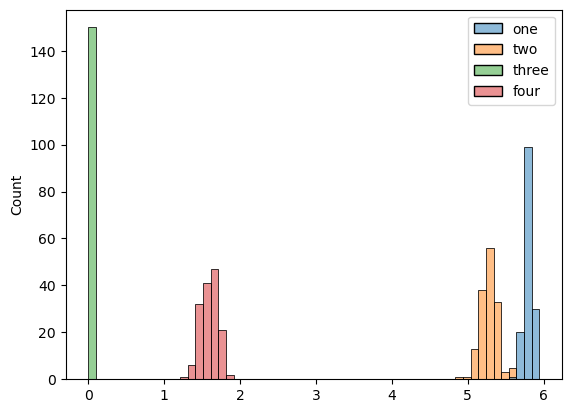

In [13]:
import seaborn
import pandas
import seaborn.objects
print(values)
print(params)
valueframe = pandas.DataFrame(values, columns=["cost"])
thing1 = seaborn.objects.Plot(valueframe, x="cost").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing1.save("plot1-2 in sample costs 150 tests 40 sample size each")
print(min(values)==max(values))
print()
thing1
paramar = pandas.DataFrame(params,columns=["one","two","three","four"])

print(max(paramar["three"]))
thign2=seaborn.histplot(paramar,binwidth=0.1)
thign2.get_figure().savefig("plot2-2 first phase results 150 tests 40 sample size each")


Here we compile a second phase problem with the first phase parameters as paramers to see the performance of the perviously generated sollutions

In [30]:
cases = 1
#we just take the all scenario set for these and then varry the supply limitations
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
cinstall =[10.,7.,16.,6.]   #costs for instalation
#costs
ps = [0.6,0.4]
ts2 = [5,7.5]
ts3 = [0.5,1.75]
timecostvecs = [[10*ps[a]*ps[b],ts2[a]*ps[a]*ps[b],ts3[b]*ps[a]*ps[b]] for a in range(2) for b in range(2)]
costsvec= [v*i*p/cases for p in probs for t in range(4) for v in timecostvecs[t]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage

cset = costsvec*cases

randvals= np.random.uniform(size=cases*4)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
randvals =  cp.Parameter(shape=cases*4 ,value= [randvals[x*4+k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)])
x=cp.Variable(len(cset) )

capacities =cp.Parameter(shape=4, value=[3,3,3,3])
#phase 1 constraints
#budget
constr = [x>=0]
#constr = constr+[x[0:4]@cinstall<=120 ]

#energy requirement constraint
#not a hard constraint anymore but still sensible to have some version of it
#constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

#phase 2 constaints
#energy supply
print(len(cset))

base= np.array([0,1,2,3,4]) 
multidin2 = np.array([1,1,1,1,1])
constr = constr + [-x[base+k*5]@multidin2<= demands[(k//12)%27][k%3] for k in range(cases*27*3*4)]
print([0,1,2,3,4][0:4])
print(constr[-1])
#capacity
base= np.array([0,5,10]) 
multiding = np.array([1,1,1])
constr = constr + [capacities[k]*randvals[(v//108)*4+k]-x[base+k+v*15]@multiding>=0.  for v in range(108*cases) for k in range(4)]
print(constr[-1])

1620
[0, 1, 2, 3]
-var89526292[1615 1616 1617 1618 1619] @ [1. 1. 1. 1. 1.] <= -3.0
0.0 <= param89526293[3] @ param89526291[3] + -var89526292[1608 1613 1618] @ [1. 1. 1.]


compile it

In [31]:
cset = np.array(cset)
lilproblem = cp.Problem(cp.Minimize(cset.T @x),constr )
t1 = time.time()
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res= lilproblem.solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)

    
t2 = time.time()
print(x.value)
print(lilproblem.value)  
print( lilproblem.variables())
print(t2-t1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558038
Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Set parameter TimeLimit to value 100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 22 11:46:07 PM: Your problem has 1620 variables, 2376 constraints, and 8 parameters.
(CVXPY) Oct 22 11:46:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 11:46:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 22 11:46:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-----------------------------------------------------------

e:\optim uncertain\.conda\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


(CVXPY) Oct 22 11:46:07 PM: Applying reduction QpMatrixStuffing
(CVXPY) Oct 22 11:46:08 PM: Applying reduction GUROBI
(CVXPY) Oct 22 11:46:08 PM: Finished problem compilation (took 8.552e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 22 11:46:08 PM: Invoking solver GUROBI  to obtain a solution.
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 3700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2558038 - for non-commercial use only - registered to r.___@student.rug.nl
Optimize a model with 2376 rows, 1620 columns and 4536 nonzeros
Model fingerprint: 0x611a9173
Coefficient statistics:
 

Here we solve our second phase problem for our first phase parameters previously generated

In [17]:
ntests=50
rndvl= lhs(4,ntests)
rndvl = [[rndvl[x+t][k]*adds[k]+mins[k]  for x in range(cases) for k in range(4)] for t in range(ntests)]
print(rndvl)
valuevector = []
for Val in range(len(params)):
    print(Val)
    capacities.value = params[Val]
    curval =params[Val]@[10.,7.,16.,6.]
    for t in rndvl:
        randvals.value = t
        lilproblem.solve(QCPDual = 1, solver  = cp.GUROBI, env=env )
        curval = curval +lilproblem.value/ntests
    valuevector = valuevector +[curval]

[[0.8794636917278693, 0.7908350280988781, 0.7894406389654711, 0.9378880279375879], [0.6455046832279239, 0.7766031569784974, 0.7195818482951968, 0.9171478494117041], [0.8470255640785302, 0.7213918309207525, 0.6697694657532058, 0.9253024084947334], [0.8393804714721242, 0.743367285516455, 0.7248281222775665, 0.9947545306603457], [0.8200870418732562, 0.7685201498135039, 0.7870831565373935, 0.9834876887084398], [0.7214324775951203, 0.7866678135976354, 0.6397384554065854, 0.9671894988699422], [0.7402926473309748, 0.7440148620248366, 0.6834202950415403, 0.9405107849049097], [0.6198082807860807, 0.7417904535530415, 0.6112805182267457, 0.9231419031547695], [0.6076078431065769, 0.7002894059083855, 0.7581322561075532, 0.9307707115051169], [0.8728424712329794, 0.7129501710827136, 0.5231845965268618, 0.9726051269667457], [0.6813425391892216, 0.7638411283279218, 0.6524302133626291, 0.9024238375673418], [0.8542460708131268, 0.795768619990249, 0.6009258610418079, 0.92021443320872], [0.6415236549066077

here we summarise and plot the outcomes of these simulations

[5.81523636 5.24868244 0.         1.65500949]
410.9384935524702
104.82319758164085


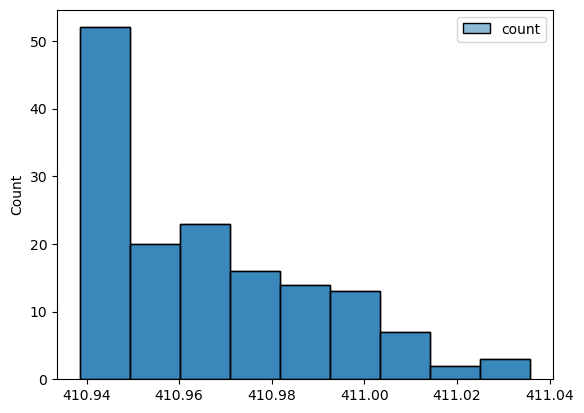

In [19]:
import pandas
seaborn.histplot(valuevector)
valuevectorpd = pandas.DataFrame(valuevector, columns=["count"])
valuevectorpd.to_csv("Bout of sample cost with 200 trials of 150 cases of 40 iteration first phase parameters")
seaborn.histplot(valuevectorpd).get_figure().savefig("plot3B out of sample cost with 150 trials of 150 cases of 40 iteration first phase parameters")

print(params[ valuevector.index(min(valuevector))])
optipars = params[ valuevector.index(min(valuevector))]
print(min(valuevector))
print(sum( [params[ valuevector.index(min(valuevector))][k]*[10.,7.,16.,6.][k] for k in range(4)]))

In [17]:

print(min(valuevector))
print(params[valuevector.index(min(valuevector))])
print(params[valuevector.index(min(valuevector))]@cinstall)


411.3626059272659
[5.65240371 5.41895861 0.         1.65029521]
104.35851861149396


this is the point we do wait and see for the whole problem, we genrate this multiple times as tau cannot be paramaterised due to being part of the cost vector

In [72]:
def makemat(times):
    #we just take the all scenario set for these and then varry the supply limitations
    #demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
    #probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
    cinstall =[10.,7.,16.,6.]   #costs for instalation
    #costs
    #ps = [0.6,0.4]
    #ts2 = [5,7.5]
    #ts3 = [0.5,1.75]
    #timecostvecs = [[10*ps[a]*ps[b],ts2[a]*ps[a]*ps[b],ts3[b]*ps[a]*ps[b]] for a in range(2) for b in range(2)]
    #setT = cp.Parameter(shape=2, value=[6,1])
    #times = [10, setT[0], setT[1]]
    costsvec = [v*i for v in times for i in [4,4.5,3.2,5.5, 10]]
    #costsvec= [v*i*p/nreal for p in probs for t in range(4) for v in timecostvecs[t]   for i in [4,4.5,3.2,5.5, 10] ]#add cost of usage
    cset = cinstall+costsvec
    randvals= [0.5,0.5,0.5,0.5]
    mins = [0.6,0.7,0.5,0.9]
    adds = [0.3,0.1,0.3,0.1] 
    randvals =  cp.Parameter(shape=4 ,value= [randvals[k]*adds[k]+mins[k]   for k in range(4)])
    x=cp.Variable(len(cset) )
    #phase 1 constraints
    #budget
    constr = [x>=0]
    constr = constr+[x[0:4]@cinstall<=120 ]

    #energy requirement constraint
    #not a hard constraint anymore but still sensible to have some version of it
    #constr = constr + [x[0:4]@[0.9,0.8,0.8,1.]>= 5]

    #phase 2 constaints
    #energy supply
    print(len(cset))
    dems = cp.Parameter(shape=3, value=[-5,-3,-2])
    base= np.array([0,1,2,3,4]) 
    multidin2 = np.array([1,1,1,1,1])
    constr = constr + [-x[base+k*5+4]@multidin2<= dems[k] for k in range(3)]
    print([0,1,2,3,4][0:4])
    print(constr[-1])
    #capacity
    base= np.array([4,9,14]) 
    multiding = np.array([1,1,1])
    constr = constr + [x[k]*randvals[k]-x[base+k]@multiding>=0.  for k in range(4)]
    print(constr[-1])
    cset = np.array(cset)
    print(cset)
    print(constr)
    return [cp.Problem(cp.Minimize(cset.T @x),constr ), dems,randvals,x]


here we compile it once as a test

In [73]:
    
t2 = time.time()
perfset = makemat([10,6,1])
print(perfset)
env = gurobipy.Env()
env.setParam('TimeLimit', 100)
res = perfset[0].solve(verbose = True, QCPDual = 1, solver  = cp.GUROBI, env=env)
t1= time.time()
print(t2-t1)
print(res)
print(perfset[3].value)
print(perfset[0].value)  

19
[0, 1, 2, 3]
-var89560347[14 15 16 17 18] @ [1. 1. 1. 1. 1.] <= param89560359[2]
0.0 <= var89560347[3] @ param89560346[3] + -var89560347[ 7 12 17] @ [1. 1. 1.]
[ 10.    7.   16.    6.   40.   45.   32.   55.  100.   24.   27.   19.2
  33.   60.    4.    4.5   3.2   5.5  10. ]
[Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ()))]
[Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(C

Here we operate the wait and see and also generate a weighted vector for the different outcomes, for every different set of tau we generate a new problem

In [96]:
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
ps = [0.6,0.4]
ts2 = [5,7.5]
ts3 = [0.5,1.75]
weights = []
costs = []
pars = []
nums=2000
alphas = lhs(4,nums)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
alphas = [[alphas[t][k]*adds[k]+mins[k] for k in range(4)] for t in range(nums)]

for T3 in range(2):
    for T2 in range(2):
        perfset = makemat([10,ts2[T2],ts3[T3]])
        for DE in range(len(demands)):
            print([T3,T2,DE])
            perfset[1].value = demands[DE]
            weights = weights + [ps[T3]*ps[T2]*probs[DE]/nums]*nums
            for a in alphas:
                perfset[2].value=a
                res = perfset[0].solve(solver  = cp.GUROBI, env=env)
                costs.append(res)
                pars.append(perfset[3].value[0:4])

19
[0, 1, 2, 3]
-var89886212[14 15 16 17 18] @ [1. 1. 1. 1. 1.] <= param89886224[2]
0.0 <= var89886212[3] @ param89886211[3] + -var89886212[ 7 12 17] @ [1. 1. 1.]
[ 10.     7.    16.     6.    40.    45.    32.    55.   100.    20.
  22.5   16.    27.5   50.     2.     2.25   1.6    2.75   5.  ]
[Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ()))]
[0, 0, 0]
[0, 0, 1]
[0, 0, 2]
[0, 0, 3]
[0, 0, 4]
[0, 0, 5]
[0, 0, 6]
[0, 0, 7]
[0, 0, 8]
[0, 0, 9]
[0, 0, 10]
[0, 0, 11]
[0, 0, 12]
[0, 0, 13]
[0, 0, 14]
[0, 0, 15]
[0, 0, 16]
[0, 0, 17]
[0, 0, 18]
[0, 0, 19]
[0, 0, 20]
[0, 0, 21]
[0, 0, 22]
[0, 0, 23]
[0, 0, 24]
[0, 0, 25]
[0, 0, 26]
19
[0, 1, 2, 3]
-var89886

here we plot the data generated by the wait and see

392.7391420130101


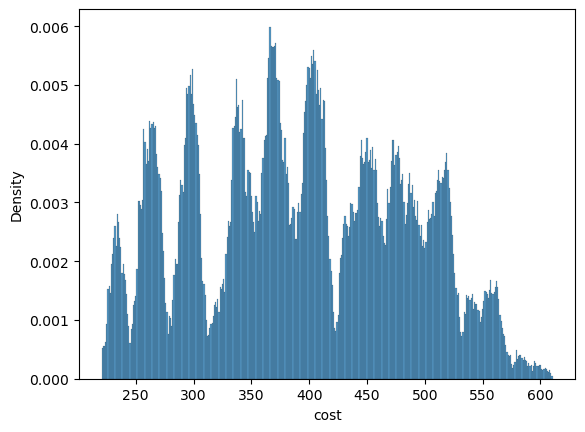

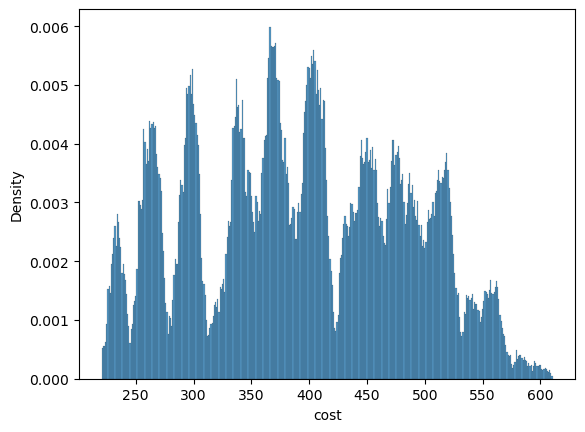

In [116]:
print(np.sum([costs[i]*weights[i] for i in range(len(weights)) ]))
costvecpd = pandas.DataFrame(costs, columns=["cost"])
costvecpd["weights"]=weights
thing1 = seaborn.histplot(costvecpd, x="cost", weights="weights",binwidth=1,stat="density").get_figure()
# thing1 = seaborn.objects.Plot(costvecpd, x="cost", weights= "weights").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing1.savefig("plot8 wait and see problem 3 1k of each")
thing1

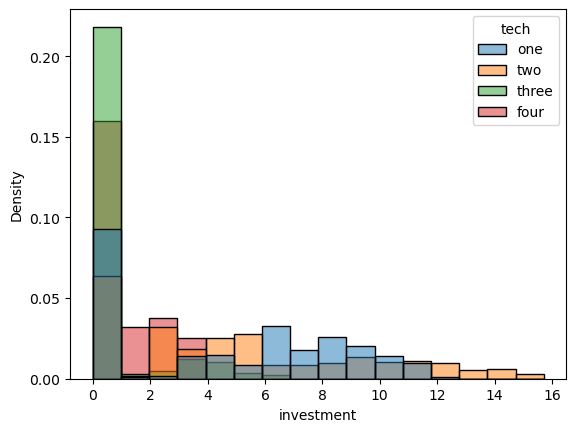

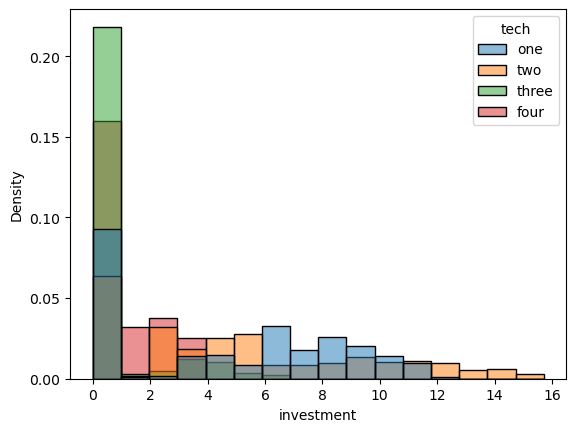

In [115]:
perfsetpd = pandas.DataFrame(pars, columns=["one","two","three", "four"])
perfsetpd["weights"]=weights
testing = pandas.DataFrame([k for x in pars for k in x], columns=["investment"])
testing["tech"] = ["one","two","three", "four"]*len(pars)
testing["weight"] = [i  for i in weights for k in range(4)] 
thing2 = seaborn.histplot(data=testing, x="investment", weights="weight", hue="tech", binwidth=1, multiple="layer",stat="density").get_figure()
# thing1 = seaborn.objects.Plot(costvecpd, x="cost", weights= "weights").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing2.savefig("plot9 wait and see problem 3 1k of each PARS")
thing2

Here we repeat the same exersize but for the extension 2, only generating one problem

In [117]:
demands = [[z,j,i] for i in [-1,-2,-3] for j in [-2,-3,-4] for z in  [-3,-5,-7] ]
probs = [z*j*i for i in [0.3,0.4,0.3] for j in [0.3,0.4,0.3] for z in [0.3,0.4,0.3]]
ps = [0.6,0.4]
ts2 = [5,7.5]
ts3 = [0.5,1.75]
weights = []
costs = []
pars = []
nums=8000
alphas = lhs(4,nums)
mins = [0.6,0.7,0.5,0.9]
adds = [0.3,0.1,0.3,0.1] 
alphas = [[alphas[t][k]*adds[k]+mins[k] for k in range(4)] for t in range(nums)]

perfset = makemat([10,6,1])
for DE in range(len(demands)):
    print(DE)
    perfset[1].value = demands[DE]
    weights = weights + [probs[DE]/nums]*nums
    for a in alphas:
        perfset[2].value=a
        res = perfset[0].solve(solver  = cp.GUROBI, env=env)
        costs.append(res)
        pars.append(perfset[3].value[0:4])

19
[0, 1, 2, 3]
-var89887136[14 15 16 17 18] @ [1. 1. 1. 1. 1.] <= param89887148[2]
0.0 <= var89887136[3] @ param89887135[3] + -var89887136[ 7 12 17] @ [1. 1. 1.]
[ 10.    7.   16.    6.   40.   45.   32.   55.  100.   24.   27.   19.2
  33.   60.    4.    4.5   3.2   5.5  10. ]
[Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Expression(AFFINE, UNKNOWN, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, ZERO, ()))]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


plottign the results again

393.87351963144346


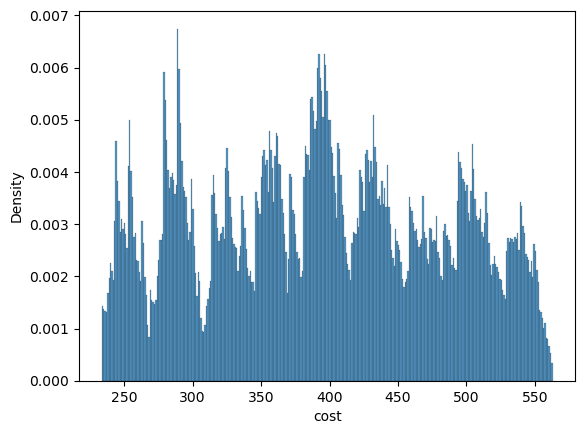

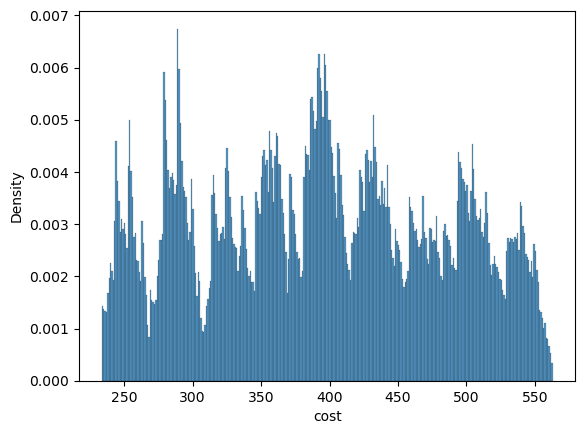

In [120]:
print(np.sum([costs[i]*weights[i] for i in range(len(weights)) ]))
costvecpd = pandas.DataFrame(costs, columns=["cost"])
costvecpd["weights"]=weights
thing1 = seaborn.histplot(costvecpd, x="cost", weights="weights",binwidth=1,stat="density").get_figure()
# thing1 = seaborn.objects.Plot(costvecpd, x="cost", weights= "weights").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing1.savefig("plot8-2 wait and see problem 3 1k of each")
thing1

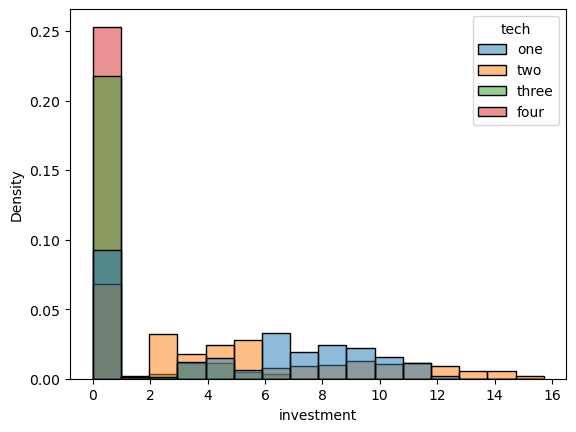

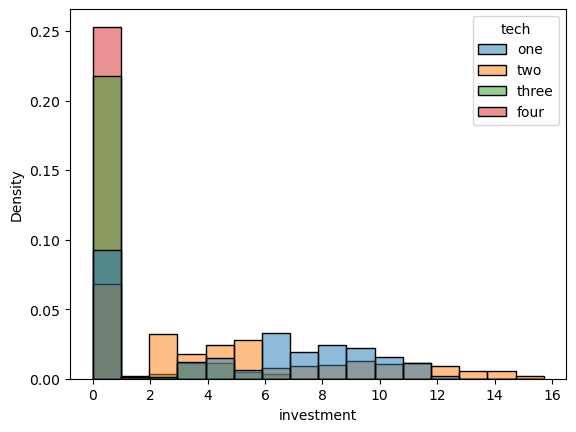

In [121]:
perfsetpd = pandas.DataFrame(pars, columns=["one","two","three", "four"])
perfsetpd["weights"]=weights
testing = pandas.DataFrame([k for x in pars for k in x], columns=["investment"])
testing["tech"] = ["one","two","three", "four"]*len(pars)
testing["weight"] = [i  for i in weights for k in range(4)] 
thing2 = seaborn.histplot(data=testing, x="investment", weights="weight", hue="tech", binwidth=1, multiple="layer",stat="density").get_figure()
# thing1 = seaborn.objects.Plot(costvecpd, x="cost", weights= "weights").add( seaborn.objects.Bars(),seaborn.objects.Hist())
#thing1=seaborn.histplot(valueframe, x="cost")
thing2.savefig("plot9-2 wait and see problem 3 1k of each PARS")
thing2